# <center><u>Flood Risk Machine Learning Tutorial</u></center>

### Introduction

<p>Urban flooding causes billions of dollars in damages annually, with severe flood events becoming more frequent and destructive as our climate changes. While extreme weather is a primary driver of flooding, its consequences depend on the interconnectedness of urban systems - referred to as the Urban Multiplex, which includes the power grid, transportation network, natural surface water and groundwater systems, sewerage and drinking water systems, intertwined with the socioeconomic and public health sectors.</p>

<p>This tutorial introduces machine learning concepts through an application in one component of the Urban Multiplex - building classification. Accurate and standardized information about buildings (e.g. classification into residential, commercial, industrial) is critical for assessing the number of people affected by flooding, the propagation of shocks throughout the economy, and for forecasting detailed socioeconomic risk from flooding. Yet, a major discrepancy exists in the way data about buildings are collected across the U.S. There is no harmonization in what data are recorded by city, county, or state governments, let alone at the national scale.</p>

<p>In this tutorial we explore multiple means of classifying a building (residential/classification/industrial/etc.) based on its features (location, square footage, proximity to other resources, etc.). Moreover, we are interested in how accurate or machine learning models can be using only free and open data. The data used in this tutorial is consistently and openly available for the continental Unites States. We use the state of North Carolina as an expemplar in this tutorial.</p>

#### Import required Python libraries

In [1]:
import time
import pickle
#import itertools
import numpy as np
import pandas as pd
#import utilities as utils
#import configuration as config
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.utils import to_categorical
from tensorflow.keras.layers import Dense
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential

from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

#### Setup and Configuration

In [4]:
# North Carolina data
url = "https://github.com/geo-smart/flood-risk-ml-tutorial/blob/main/North_Carolina_Buildings.zip?raw=true"

# read data into a Pandas dataframe
rawDf = pd.read_csv(url, compression="zip")

# ignore first few columns, which are FIPs codes, not needed for ML
rawDf = rawDf.iloc[:, 3:] 
df = rawDf.copy( deep=True )

#### The data

Our data is a combination of values aggregated from [Open Street Map (OSM)](https://www.openstreetmap.org), the [Multi-Resolution Land Characteristics Consortium (MRLC)](https://www.mrlc.gov/data/type/urban-imperviousness), [United States Census' County Business Patterns (CBP)](https://www.census.gov/programs-surveys/cbp/data/tables.html), and the [United States Census' American Community Survey (ACS)](https://www.census.gov/programs-surveys/acs/data.html).

| Column      | Description | Source |
| :---------: | :---------- |:-------|
| X                    | Title       | OSM |
| Y                    | Text        | OSM |
| Area                 | Area of building in square meters        | OSM |
| MedianIncomeCounty   | Median income of the county in which the building resides        | ACS |
| HousingUnitsCounty   | Number of housing units in the county in which the building resides | ACS |
| HousingDensityCounty | Number of housing units in the county divided by the number of people residing in the county where the building resides        | ACS |
| Impervious           | Percentage of the area surrounding the building that is comprised of impervious surfaces such as roads and other paved surfaces  | MRLC |
| AgCount              | Number of agricultural businesses in the county in which the building resides | CBP |
| CmCount              | Number of commercial businesses in the county in which the building resides   | CBP |
| GvCount              | Number of government buildings in the county in which the building resides    | CBP |
| EdCount              | Number of educational buildings in the county in which the building resides   | CBP |
| InCount              | Number of industrial buildings in the county in which the building resides    | CBP |
| OsmNearestRoad       | Type of nearest road to the building | OSM |
| OrnlType             | Building classification | ORNL |

In [6]:
rawDf.head()

,X,Y,Area,MedianIncomeCounty,HousingUnitsCounty,HousingDensityCounty,Impervious,AgCount,CmCount,GvCount,EdCount,InCount,OsmNearestRoad,OrnlType
0,-83.261157,35.484491,21.951055,22429.0,26649.0,0.618177,4.000000,22,2860,3,51,804,residential,Residential
1,-83.260972,35.484583,255.155551,22429.0,26649.0,0.618177,5.666667,22,2860,3,51,804,residential,Residential
2,-83.260417,35.484768,184.625376,22429.0,26649.0,0.618177,7.000000,22,2860,3,51,804,residential,Residential
3,-83.256806,35.492268,434.205428,22429.0,26649.0,0.618177,22.500000,22,2860,3,51,804,residential,Residential
4,-83.156435,35.493657,138.361515,22429.0,26649.0,0.618177,4.000000,22,2860,3,51,804,secondary,Residential


#### Data exploration

In [8]:
# building type distributions
print( "Building types and their counts" )
print()
print( df['OrnlType'].value_counts() )
print()

Building types and their counts

Residential         976690
Commercial           64029
Industrial           16722
Assembly              7323
Education             6457
Government            4910
Agriculture           1651
Utility and Misc       362
Name: OrnlType, dtype: int64



In [9]:
print( "Building type counts as compared to the largest class" )
print()
976690/df['OrnlType'].value_counts()

Building type counts as compared to the largest class



Residential            1.000000
Commercial            15.253869
Industrial            58.407487
Assembly             133.372935
Education            151.260647
Government           198.918534
Agriculture          591.574803
Utility and Misc    2698.038674
Name: OrnlType, dtype: float64

<p>We have significant class imbalance. For example, the residential buildings outnumber the commercial buildings 15 to 1. The residentail buildings outnumber the agricultural buildings nearly 600 to 1. This can be a challenge for machine learning classification algorithms. The algorithm may not "learn", but rather obtain high accuracy simply by picking the majority class.</p>

<p>We will look at techniques for dealing with such imbalance</p>

### Binary classification

<p>The OsmNearestRoad and OrnlType are currently text. We need to encode these as integers before proceeding with machine learning. We also want to scale our columns to a common axis so that columns with large values don't bias the learning.</p>

<p>We'll use a standard scaler, which scales based on the standard scoreas: z = (x - u) / s</p>
<p>Where u is the mean of the training samples and s is the standard deviation of the training samples</p>

<p>In this first example, we'll look at Binary classification. Binary class is two class classification. We'll look at determining if a building is "Residential" or "Other" where "Other" is all the non-residentail buildings combined.</p>

In [10]:
df.loc[df["OrnlType"] != "Residential", "OrnlType"] = 'Other'

df = df.sample(frac=1) # shuffle the dataframe (technically, we randomly resample the entire df)

# preprocess the data - scaling
scaler = preprocessing.StandardScaler()
    
columns = ['X', 'Y', 'Area', 'MedianIncomeCounty', 
           'HousingUnitsCounty', 'HousingDensityCounty',
           'Impervious', 'AgCount', 'CmCount', 'GvCount',
           'EdCount', 'InCount']
df[columns] = scaler.fit_transform(df[columns])

# preprossing - drop rows with NaN values
df = df.dropna()
    
# preprocessing - change output labels from text ('Agriculture') to integers
nCols = df.shape[1]
le = preprocessing.LabelEncoder()
le.fit( df.iloc[:, nCols-1] )
df.iloc[:, nCols-1] = le.transform( df.iloc[:, nCols-1] )
        
# preprocessing - change output labels of nearest road type from text to integers
le2 = preprocessing.LabelEncoder()
le2.fit( df.iloc[:, nCols-2] ) 
df.iloc[:, nCols-2] = le2.transform( df.iloc[:, nCols-2] )

<p>Some machine learning algorithms, e.g. Random Forest, don't require scaling. We'll create a second dataframe with OsmNearestRoad and OrnlType encoded, but without the scaling</p> 

In [11]:
rawDf.loc[rawDf["OrnlType"] != "Residential", "OrnlType"] = 'Other'

rawDf = rawDf.sample(frac=1) # shuffle the dataframe (technically, we randomly resample the entire df)

rawDf = rawDf.dropna()

nCols = rawDf.shape[1]
le = preprocessing.LabelEncoder()
le.fit( rawDf.iloc[:, nCols-1] ) # ornl type
rawDf.iloc[:, nCols-1] = le.transform( rawDf.iloc[:, nCols-1] )
    
le2 = preprocessing.LabelEncoder()
le2.fit( rawDf.iloc[:, nCols-2] ) # nearest road type
rawDf.iloc[:, nCols-2] = le2.transform( rawDf.iloc[:, nCols-2] )

<p>Our "OrnlType" values are now encoded as 0 or 1. We can use the inverse_transform to see which one is which.</p>

In [13]:
df.head()

,X,Y,Area,MedianIncomeCounty,HousingUnitsCounty,HousingDensityCounty,Impervious,AgCount,CmCount,GvCount,EdCount,InCount,OsmNearestRoad,OrnlType
291689,-1.177495,-0.554531,-0.022705,-1.327048,-0.994500,0.052691,-0.803153,-1.277726,-1.082940,-1.048588,-1.134246,-1.068329,4,1
639435,-1.036932,-0.869745,-0.147610,0.337253,1.051850,0.031186,-0.251473,-0.337799,1.140185,1.278110,0.949244,0.979654,4,1
240623,0.955903,-0.229497,-0.088269,-0.803459,-1.068631,-0.697542,-0.982076,0.033225,-1.138290,-1.189600,-1.155967,-0.976654,4,1
1064177,0.619026,1.199258,-0.032880,0.061124,-0.745051,0.324158,-1.160999,-1.277726,-0.785143,-0.625552,-0.540825,-1.002265,4,1
967278,0.727775,0.668362,-0.068332,1.302284,0.963812,-0.339621,0.784791,1.665731,0.880503,0.643556,1.097817,1.041934,4,1


In [12]:
le.inverse_transform([0,1])

array(['Other', 'Residential'], dtype=object)

In [14]:
df['OrnlType'].value_counts()

1    976689
0    101453
Name: OrnlType, dtype: int64

In [15]:
976689/df['OrnlType'].value_counts()

1    1.00000
0    9.62701
Name: OrnlType, dtype: float64

<p>We still have nearly 10 times more residential buildings as "other" buildings. Let's proceed with various classification techniques and see how we do.</p>

### K-Neasest Neighbors (K-NN)

<p>With K-NN we... k-fold, balanced accuracy, mico f1</p>

In [17]:
kf = KFold( n_splits=5, shuffle=True, random_state=42 )

X = df.drop(['OrnlType'], axis=1).values
y = df['OrnlType'].values

ks = [3,5,7,9]
for k in ks:
    fold = 1
    accs = []
    print( "K:", k )
    for trainIndex, testIndex in kf.split(X):
        X_train, X_test = X[trainIndex], X[testIndex]
        y_train, y_test = y[trainIndex], y[testIndex]
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit( X_train, y_train )
        predictions = knn.predict(X_test)
        ba = np.round( balanced_accuracy_score(y_test, predictions), 4 )
        print( "  Fold:", fold )
        print( "  Balanced Accuracy:", ba )
        print( "  Micro F1:", np.round( f1_score(y_test, predictions, average='micro'), 4 ))
        print()
        accs.append( ba )
        fold += 1
    print( "Average Balance Accuracy:", np.round(np.mean(accs),4) )
    print()

K: 3
  Fold: 1
  Balanced Accuracy: 0.8269
  Micro F1: 0.9513

  Fold: 2
  Balanced Accuracy: 0.828
  Micro F1: 0.9512

  Fold: 3
  Balanced Accuracy: 0.8265
  Micro F1: 0.9506

  Fold: 4
  Balanced Accuracy: 0.8277
  Micro F1: 0.9517

  Fold: 5
  Balanced Accuracy: 0.8273
  Micro F1: 0.9512

Average Balance Accuracy: 0.8273

K: 5
  Fold: 1
  Balanced Accuracy: 0.8269
  Micro F1: 0.9531

  Fold: 2
  Balanced Accuracy: 0.8273
  Micro F1: 0.9528

  Fold: 3
  Balanced Accuracy: 0.828
  Micro F1: 0.9528

  Fold: 4
  Balanced Accuracy: 0.8296
  Micro F1: 0.954

  Fold: 5
  Balanced Accuracy: 0.8286
  Micro F1: 0.9531

Average Balance Accuracy: 0.8281

K: 7
  Fold: 1
  Balanced Accuracy: 0.8279
  Micro F1: 0.9541

  Fold: 2
  Balanced Accuracy: 0.8282
  Micro F1: 0.954

  Fold: 3
  Balanced Accuracy: 0.8271
  Micro F1: 0.9534

  Fold: 4
  Balanced Accuracy: 0.8286
  Micro F1: 0.9544

  Fold: 5
  Balanced Accuracy: 0.8266
  Micro F1: 0.9533

Average Balance Accuracy: 0.8277

K: 9
  Fold: 1
  

K = 5 gave the best results. We'll train a model using all the data and K=5. We also demonstrate writing the model to a [Python Pickle](https://docs.python.org/3/library/pickle.html) file for later reuse.

In [20]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit( X, y )

# save the model to a Python Pickle
with open('./knn_5_model.pkl', 'wb') as f:
    pickle.dump(knn, f)

In [21]:
# read the model from file                                                                                                                                                                                                         
with open('./knn_5_model.pkl', 'rb') as f:
    knn = pickle.load(f)

# use the model to make predictions
predictions = knn.predict(X)
print("Predictions:", predictions[0:5])
print("Actual:", y[0:5])

Predictions: [1 1 1 1 1]
Actual: [1 1 1 1 1]


<p>Visualize the results using a confusion matrix</p>

In [22]:
cm = confusion_matrix( y, predictions, normalize='true' )

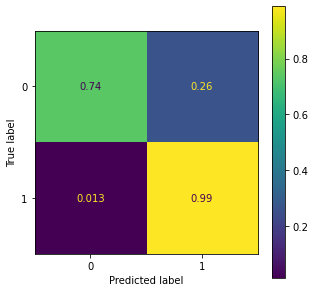

In [23]:
fig, ax = plt.subplots(figsize=(5, 5))
disp = ConfusionMatrixDisplay( confusion_matrix=cm, display_labels=knn.classes_ )
disp.plot(ax=ax)

<p>We correctly predict "Other" 74% of the time while correctly predicting "Residential" 99% of the time. 26% of the time we predict "Residential" when we should have predicted "Other" and ~1% of the time we predict "Other" when we should have predicted "Residential".</p>

### Random Forest

Random Forest does not require data values to be scaled. Let's apply Random Forest to our unscaled dataframe.

In [24]:
rawDf.head()

,X,Y,Area,MedianIncomeCounty,HousingUnitsCounty,HousingDensityCounty,Impervious,AgCount,CmCount,GvCount,EdCount,InCount,OsmNearestRoad,OrnlType
472279,-78.382731,33.975972,524.149027,30529.0,88330.0,0.646193,54.333333,44,8035,3,113,2188,4,0
1024613,-78.920324,35.934769,178.254200,35085.0,144559.0,0.445026,27.500000,0,26758,12,892,3732,4,1
12616,-80.583565,35.313380,211.072200,34297.0,87410.0,0.387106,42.666667,19,14422,6,289,3751,4,1
867992,-78.532639,35.784120,347.930397,41189.0,462582.0,0.409578,6.250000,119,105723,30,2778,17780,4,1
587696,-80.796991,35.039398,194.211800,36443.0,478966.0,0.429380,35.333333,38,118034,39,2607,17352,4,1


In [25]:
kf = KFold( n_splits=5, shuffle=True, random_state=42 )
rf = RandomForestClassifier(class_weight='balanced')

X = rawDf.drop(['OrnlType'], axis=1).values
y = rawDf['OrnlType'].values

accs = []
fold = 1
for trainIndex, testIndex in kf.split(X):
    X_train, X_test = X[trainIndex], X[testIndex]
    y_train, y_test = y[trainIndex], y[testIndex]
    rf.fit( X_train, y_train )
    ba = np.round( balanced_accuracy_score(y_test, rf.predict(X_test)), 4 )
    accs.append( ba )
    print( "Fold:", fold )
    print( "  Balanced Accuracy:", ba)
    print( "  Micro F1:", np.round( f1_score(y_test, rf.predict(X_test), average='micro'), 4 ))
    print()
    fold += 1
print( "Average Balanced Accuracy:", np.round(np.mean(accs),4) )

Fold: 1
  Balanced Accuracy: 0.8559
  Micro F1: 0.9626

Fold: 2
  Balanced Accuracy: 0.8559
  Micro F1: 0.9622

Fold: 3
  Balanced Accuracy: 0.859
  Micro F1: 0.9631

Fold: 4
  Balanced Accuracy: 0.8508
  Micro F1: 0.9611

Fold: 5
  Balanced Accuracy: 0.8522
  Micro F1: 0.9618

Average Balanced Accuracy: 0.8548


In [31]:
rf.fit( X_train, y_train )

with open('./rf_model.pkl', 'wb') as f:
    pickle.dump(rf, f)

In [32]:
# read the model from file                                                                                                                                                                                                         
with open('./rf_model.pkl', 'rb') as f:
    rf = pickle.load(f)

predictions = rf.predict(X_test)
print( "Predictions:", predictions[0:5] )
print( "Actual:", y_test[0:5] )

Predictions: [1 1 1 1 1]
Actual: [1 1 1 1 1]


In [34]:
cm = confusion_matrix( y_test, predictions, normalize='true' )

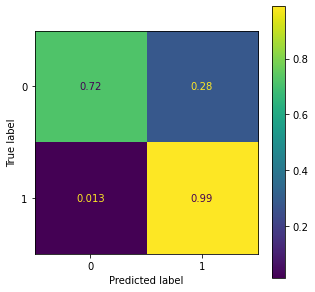

In [35]:
fig, ax = plt.subplots(figsize=(5, 5))
disp = ConfusionMatrixDisplay( confusion_matrix=cm, display_labels=rf.classes_)
disp.plot(ax=ax)

### Neural Network

In [37]:
# This is required for my GPU: GeForce RTX 2060
# Without this config, tensorflow cannot properly allocate GPU memory

# This is a GPU specific configuration and may not be needed on your GPU

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.90
session = tf.compat.v1.Session(config=config)

2023-01-09 12:20:35.334122: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-09 12:20:35.334490: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-09 12:20:35.334752: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-09 12:20:35.335040: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-09 12:20:35.335278: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

In [38]:
# columns: StateFips, CountyFips, StateCountyFips,
#          X, Y, Area, MedianIncomeCounty, HousingUnitsCounty,
#          HousingDensityCounty, Impervious, AgCount, CmCount,
#          GvCount, EdCount, InCount, OsmNearestRoad, OrnlType

# test/train split
print("Creating test/train split...")
train, test = train_test_split(df, test_size=0.2, random_state=42, stratify=df[['OrnlType']])

nCols = test.shape[1]
xTest = test.iloc[:, :nCols-2]
yTest = test.iloc[:, nCols-1]

xTrain = train.iloc[:, :nCols-2]
yTrain = train.iloc[:, nCols-1]

Creating test/train split...


In [39]:
print("Training Size:", xTrain.shape)
print("Testing Size:", xTest.shape)

Training Size: (862513, 12)
Testing Size: (215629, 12)


<p>We want the neural network to weight the fewer "other" examples that are available. You can do this by passing Keras weights for each class through a parameter. These will cause the model to "pay more attention" to examples from an under-represented class.</p>

In [44]:
## A common weighting technique that involves the dataset size
## and the number of examples in each class.

# Scaling by total/2 helps keep the loss to a similar magnitude.
total = xTrain.shape[0]
ix = np.where( yTrain == 0 )
zero = len(ix[0])
ix = np.where( yTrain == 1 )
one = len(ix[0])

weight_for_0 = (1 / zero) * (total / 2.0)
weight_for_1 = (1 / one) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 5.31
Weight for class 1: 0.55


<p>Define a fairly simple three layer fully connected neural network</p>
<p>We will set the network to train for 150 epochs; however, we stop the training early if accuracy hasn't improved over the previous 7 epochs</p>

In [47]:
# convert output from scalar to vector format, i.e. building type=2 to [0,0,1,0,0,0,0,0,0,0,0]
y = to_categorical(yTrain)

# define the keras model
model = Sequential()
model.add(Dense(30, input_shape=(xTrain.shape[1],), activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# stop training if we see 7 epochs over which accuracy doesn't improve
es = EarlyStopping(monitor='accuracy', patience=7)

<p>Output a summary of our neural network to see how many trainable parameters there are</p>

In [48]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 30)                390       
                                                                 
 dense_7 (Dense)             (None, 15)                465       
                                                                 
 dense_8 (Dense)             (None, 2)                 32        
                                                                 
Total params: 887
Trainable params: 887
Non-trainable params: 0
_________________________________________________________________


<p>Train the neural network</p>

In [49]:
# fit the model
h = model.fit(xTrain, y, epochs=150, batch_size=256, class_weight=class_weight, callbacks=[es])

Epoch 1/150
3370/3370 [==============================] - 12s 4ms/step - loss: 0.3610 - accuracy: 0.8736
Epoch 2/150
3370/3370 [==============================] - 12s 4ms/step - loss: 0.3415 - accuracy: 0.8940
Epoch 3/150
3370/3370 [==============================] - 13s 4ms/step - loss: 0.3364 - accuracy: 0.8938
Epoch 4/150
3370/3370 [==============================] - 12s 3ms/step - loss: 0.3320 - accuracy: 0.8937
Epoch 5/150
3370/3370 [==============================] - 16s 5ms/step - loss: 0.3282 - accuracy: 0.8937
Epoch 6/150
3370/3370 [==============================] - 12s 4ms/step - loss: 0.3263 - accuracy: 0.8934
Epoch 7/150
3370/3370 [==============================] - 12s 3ms/step - loss: 0.3250 - accuracy: 0.8937
Epoch 8/150
3370/3370 [==============================] - 8s 2ms/step - loss: 0.3240 - accuracy: 0.8934
Epoch 9/150
3370/3370 [==============================] - 11s 3ms/step - loss: 0.3230 - accuracy: 0.8941
Epoch 10/150
3370/3370 [==============================] - 10s 3ms

Text(0.5, 0, 'Epoch')

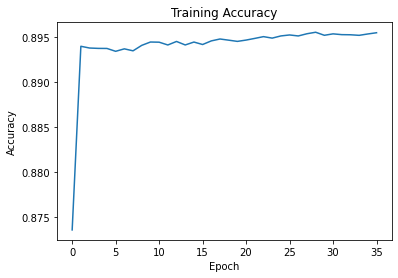

In [50]:
plt.plot( h.history['accuracy'] )
plt.title('Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

In [51]:
model.save_weights("./nn_model.h5")

Evaluate the neural network on the test set

In [52]:
y = to_categorical(yTest)
loss, acc = model.evaluate( xTest, y )
print("Accuracy on the test set:", np.round(acc,4))

6739/6739 [==============================] - 12s 2ms/step - loss: 0.3013 - accuracy: 0.8936
Accuracy on the test set: 0.8936


Use Balanced Accuracy and Micro F1 to get a better sense of how we did

In [53]:
ps = model.predict(xTest)
predictions = []
for p in ps:
    predictions.append( np.argmax( p ) )
len(predictions)

6739/6739 [==============================] - 8s 1ms/step


215629

In [54]:
print( "Balanced Accuracy:", np.round( balanced_accuracy_score(yTest.values, predictions), 4 ))
print( "Micro F1:", np.round( f1_score(yTest.values, predictions, average='micro'), 4 ))

Balanced Accuracy: 0.8744
Micro F1: 0.8936


In [55]:
cm = confusion_matrix( yTest.values, predictions, normalize='true' )

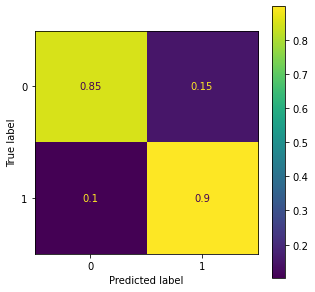

In [56]:
fig, ax = plt.subplots(figsize=(5, 5))
disp = ConfusionMatrixDisplay( confusion_matrix=cm )
disp.plot(ax=ax)

## Feature Importance

<p>Feature importance is a technique for assessing how important each of our input features are to making accurate predictions. Features with low importance do not contribute much (are not used/do not have much weight) to prediction accuracy. Low importance features can be ignored creating simpler more scalable machine learning modesl.</p>

We use a technique called [Permutation Importance](https://scikit-learn.org/stable/modules/permutation_importance.html) in which features are randomly shuffled. If a column's values can be randomly shuffled and prediction accuracy does not decrease, then that feature has low importance.

<p>We'll use our Random Forest model to demonstrate feature importance</p>

Elapsed time to compute the importances: 46.844 seconds


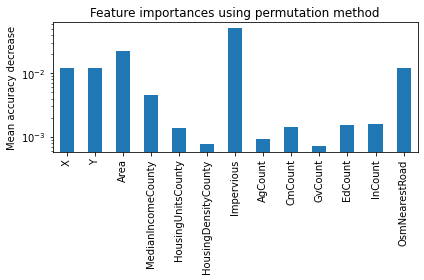

In [57]:
start_time = time.time()
result = permutation_importance(
    rf, X_test, y_test, n_repeats=1, random_state=42, n_jobs=1
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=df.columns[:-1])

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation method")
ax.set_ylabel("Mean accuracy decrease")
ax.set_yscale('log')
fig.tight_layout()
plt.show()

The features 'HousingUnitsCounty', 'HousingDensityCounty', 'AgCount', 'CmCount', 'GvCount', 'EdCount', and 'InCount' have low importance. Let's retrain a smaller Random Forest model without those features

### Remove features that are not important/helpful to simplify the model

In [58]:
kf = KFold( n_splits=5, shuffle=True, random_state=42 )
rf = RandomForestClassifier(class_weight='balanced')

X = rawDf.drop(['OrnlType', 'HousingUnitsCounty', 'HousingDensityCounty', 'AgCount', 'CmCount',
                'GvCount', 'EdCount', 'InCount'], axis=1).values
y = rawDf['OrnlType'].values

accs = []
for trainIndex, testIndex in kf.split(X):
    X_train, X_test = X[trainIndex], X[testIndex]
    y_train, y_test = y[trainIndex], y[testIndex]
    rf.fit( X_train, y_train )
    ba = np.round( balanced_accuracy_score(y_test, rf.predict(X_test)), 4 )
    accs.append( ba )
    print( "Balanced Accuracy:", ba)
    print( "Micro F1:", np.round( f1_score(y_test, rf.predict(X_test), average='micro'), 4 ))
    print()
print( "Average Balanced Accuracy:", np.round(np.mean(accs),4) )

Balanced Accuracy: 0.8482
Micro F1: 0.9603

Balanced Accuracy: 0.8477
Micro F1: 0.9599

Balanced Accuracy: 0.8498
Micro F1: 0.9605

Balanced Accuracy: 0.8435
Micro F1: 0.9593

Balanced Accuracy: 0.8464
Micro F1: 0.9601

Average Balanced Accuracy: 0.8471


Our average Balanced Accuracy from the previous Random Forest model using all the features was 85.48%. Our reduced model has accuracy of 84.71%. We can create a smaller model without much loss in accuracy.

In [59]:
with open('./rf_reduced_model.pkl', 'wb') as f:
    pickle.dump(rf, f)

## Strategies to deal with unbalanced classes

Undersampling refers to a group of techniques designed to balance the class distribution. Undersampling techniques remove examples from the training dataset that belong to the majority class in order to better balance the class distribution. 

This is in contrast to oversampling, which involves adding examples to the minority class in an effort to reduce the class distribution imbalance.

Near Miss refers to a collection of undersampling methods that select examples based on the distance of majority class examples to minority class examples.

The approaches were proposed by Jianping Zhang and Inderjeet Mani in their 2003 paper [KNN Approach to Unbalanced Data Distributions: A Case Study Involving Information Extraction](https://www.site.uottawa.ca/~nat/Workshop2003/jzhang.pdf)

There are three versions of the technique, named NearMiss-1, NearMiss-2, and NearMiss-3.

* NearMiss-1 selects examples from the majority class that have the smallest average distance to the k closest examples from the minority class. 
* NearMiss-2 selects examples from the majority class that have the smallest average distance to the k furthest examples from the minority class. 
* NearMiss-3 involves selecting a given number of majority class examples for each example in the minority class that are closest.

Distance is determined in feature space using Euclidean distance.

We'll use NearMiss-3, which keeps majority class examples that are on the decision boundary.

In [60]:
from imblearn.under_sampling import NearMiss

# define the undersampling method
undersample = NearMiss( version=3, n_neighbors_ver3=5 )

X = rawDf.drop(['OrnlType'], axis=1).values
y = rawDf['OrnlType'].values

# transform the dataset
X, y = undersample.fit_resample( X, y )

In [61]:
ix = np.where( y == 1 )
print( "Residential:", len(ix[0]) )

ix = np.where( y == 0 )
print( "Other:", len(ix[0]) )

Residential: 101453
Other: 101453


### Random Forest example of Near-Miss

In [62]:
kf = KFold( n_splits=5, shuffle=True, random_state=42 )
rf = RandomForestClassifier(class_weight='balanced')

accs = []
for trainIndex, testIndex in kf.split(X):
    X_train, X_test = X[trainIndex], X[testIndex]
    y_train, y_test = y[trainIndex], y[testIndex]
    rf.fit( X_train, y_train )
    ba = np.round( balanced_accuracy_score(y_test, rf.predict(X_test)), 4 )
    accs.append( ba )
    print( "Balanced Accuracy:", ba)
    print( "Micro F1:", np.round( f1_score(y_test, rf.predict(X_test), average='micro'), 4 ))
    print()
print( "Average Balanced Accuracy:", np.round(np.mean(accs),4) )

Balanced Accuracy: 0.8426
Micro F1: 0.8426

Balanced Accuracy: 0.841
Micro F1: 0.841

Balanced Accuracy: 0.8396
Micro F1: 0.8396

Balanced Accuracy: 0.8393
Micro F1: 0.8393

Balanced Accuracy: 0.8386
Micro F1: 0.8386

Average Balanced Accuracy: 0.8402


Our average Balanced Accuracy from the original Random Forest model was 85.48%. The Balanced Accuracy using Near-Miss-3 and balanced classed results in an accuracy of 84%. This technique was not particularly helpful for our application.

In [63]:
with open('./rf_balanced_model.pkl', 'wb') as f:
    pickle.dump(rf, f)

### Threshold Moving

Perhaps the simplest approach to handle a severe class imbalance is to change the decision threshold. Many classification algorithms will return a probability of class membership where all values equal or greater than a threshold are mapped to one class and all other values are mapped to the other class. The default of many algorithms is to set the threshold at 0.5. Threshold moving simply moves the threshold attempting to achieve higher accuracy.

In [64]:
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve

# generate dataset
X = rawDf.drop(['OrnlType'], axis=1).values
y = rawDf['OrnlType'].values

# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.2, random_state=2, stratify=y)

# fit a model
print("Fitting the model...")
model = RandomForestClassifier(class_weight='balanced')
model.fit(trainX, trainy)

# predict probabilities
print("Making predictions...")
yhat = model.predict_proba(testX)

# keep probabilities for the positive outcome only
yhat = yhat[:, 1]

# calculate precision-recall curve
print("Generating precision-recall curve...")
precision, recall, thresholds = precision_recall_curve(testy, yhat)

Fitting the model...
Making predictions...
Generating precision-recall curve...


In [65]:
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)

# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=0.530000, F-Score=0.979


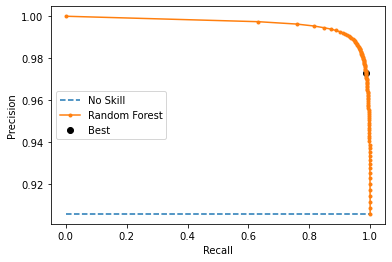

In [66]:
# plot the curve for the model
no_skill = len(testy[testy==1]) / len(testy)
pyplot.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
pyplot.plot(recall, precision, marker='.', label='Random Forest')
pyplot.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')

# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()

# show the plot
pyplot.show()

Now that we've found the best threshold, what accuracy can we achieve with it?

In [67]:
threshold = 0.53

predicted_proba = model.predict_proba(testX)
predicted = (predicted_proba [:,1] >= threshold).astype('int')

ba = np.round( balanced_accuracy_score(testy, predicted), 4 )

print( "Balanced Accuracy:", ba)
print( "Micro F1:", np.round( f1_score(testy, predicted, average='micro'), 4 ))

Balanced Accuracy: 0.8617
Micro F1: 0.9625


In [68]:
with open('./rf_model_threshold_moving.pkl', 'wb') as f:
    pickle.dump(model, f)

## Multi-class Classification

What does all of this look like if we want to do multi-class classification instead of binary classification? Let's look at trying to classify a building as "Residential", "Commercial", or "Industrial".

In [70]:
# read into a Pandas dataframe
rawDf = pd.read_csv( url, compression="zip" )

# ignore first few columns, which are FIPs codes, not needed for ML
rawDf = rawDf.iloc[:, 3:] 

# drop the rows we don't need
rawDf = rawDf[ rawDf['OrnlType'] != 'Assembly' ]
rawDf = rawDf[ rawDf['OrnlType'] != 'Education' ]
rawDf = rawDf[ rawDf['OrnlType'] != 'Government' ]
rawDf = rawDf[ rawDf['OrnlType'] != 'Agriculture' ]
rawDf = rawDf[ rawDf['OrnlType'] != 'Utility and Misc' ]

# building type distributions
print()
print( rawDf['OrnlType'].value_counts() )
print()


Residential    976690
Commercial      64029
Industrial      16722
Name: OrnlType, dtype: int64



In [71]:
# building type distributions
print()
print( 976690/rawDf['OrnlType'].value_counts() )
print()


Residential     1.000000
Commercial     15.253869
Industrial     58.407487
Name: OrnlType, dtype: float64



## Preprocess

In [72]:
rawDf = rawDf.sample(frac=1) # shuffle the dataframe (technically, we randomly resample the entire df)

rawDf = rawDf.dropna()

nCols = rawDf.shape[1]
le = preprocessing.LabelEncoder()
le.fit( rawDf.iloc[:, nCols-1] ) # ornl type
rawDf.iloc[:, nCols-1] = le.transform( rawDf.iloc[:, nCols-1] )
    
le2 = preprocessing.LabelEncoder()
le2.fit( rawDf.iloc[:, nCols-2] ) # nearest road type
rawDf.iloc[:, nCols-2] = le2.transform( rawDf.iloc[:, nCols-2] )

In [73]:
rawDf.head()

,X,Y,Area,MedianIncomeCounty,HousingUnitsCounty,HousingDensityCounty,Impervious,AgCount,CmCount,GvCount,EdCount,InCount,OsmNearestRoad,OrnlType
854989,-78.353565,35.787454,142.97180,41189.0,462582.0,0.409578,13.000000,119,105723,30,2778,17780,4,2
640627,-80.838009,35.090417,144.35040,36443.0,478966.0,0.429380,16.500000,38,118034,39,2607,17352,4,2
3356,-80.644398,35.497824,100.35720,34297.0,87410.0,0.387106,44.500000,19,14422,6,289,3751,4,2
385683,-79.841620,36.104306,302.60880,30173.0,232277.0,0.429110,17.666667,21,45798,18,915,8411,4,2
12403,-80.583287,35.310694,223.99749,34297.0,87410.0,0.387106,93.000000,19,14422,6,289,3751,4,2


## Random Forest Multiclass Classifier

In [74]:
kf = KFold( n_splits=5, shuffle=True, random_state=42 )
rf = RandomForestClassifier(class_weight='balanced')

X = rawDf.drop(['OrnlType'], axis=1).values
y = rawDf['OrnlType'].values

accs = []
for trainIndex, testIndex in kf.split(X):
    X_train, X_test = X[trainIndex], X[testIndex]
    y_train, y_test = y[trainIndex], y[testIndex]
    rf.fit( X_train, y_train )
    ba = np.round( balanced_accuracy_score(y_test, rf.predict(X_test)), 4 )
    accs.append( ba )
    print( "Balanced Accuracy:", ba)
    print( "Micro F1:", np.round( f1_score(y_test, rf.predict(X_test), average='micro'), 4 ))
    print()
print( "Average Balanced Accuracy:", np.round(np.mean(accs),4) )

Balanced Accuracy: 0.7031
Micro F1: 0.9637

Balanced Accuracy: 0.6995
Micro F1: 0.9637

Balanced Accuracy: 0.7036
Micro F1: 0.9633

Balanced Accuracy: 0.7031
Micro F1: 0.9633

Balanced Accuracy: 0.7011
Micro F1: 0.9639

Average Balanced Accuracy: 0.7021


In [75]:
with open('./rf_model_multi.pkl', 'wb') as f:
    pickle.dump(rf, f)

In [76]:
predictions = rf.predict(X_test)
cm = confusion_matrix( y_test, predictions, normalize='true' )

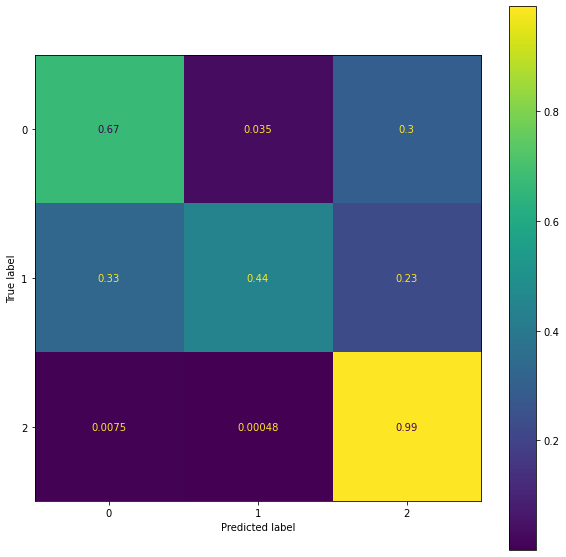

In [77]:
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay( confusion_matrix=cm, display_labels=rf.classes_)
disp.plot(ax=ax)

In [79]:
le.inverse_transform( np.arange(0,3,1) )

array(['Commercial', 'Industrial', 'Residential'], dtype=object)

Elapsed time to compute the importances: 42.437 seconds


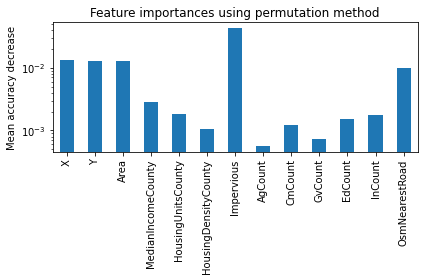

In [80]:
start_time = time.time()
result = permutation_importance(
    rf, X_test, y_test, n_repeats=1, random_state=42, n_jobs=1
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=df.columns[:-1])

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation method")
ax.set_ylabel("Mean accuracy decrease")
ax.set_yscale('log')
fig.tight_layout()
plt.show()

## One-vs-One Classification

One-vs-One is a multi-class classification strategy for dealing with unbalanced classes. The One-vs-One strategy splits a multi-class classification into one binary classification problem per each pair of classes, e.g. Residentail vs. Commercial, Residential vs. Industrial, Commercial vs. Industrial. The final class assignment is determined by aggregating the results of the binary classifiers.

In [86]:
train, test = train_test_split(rawDf, test_size=0.2, random_state=42, stratify=rawDf[['OrnlType']])

nCols = test.shape[1]
xTest = test.iloc[:, :nCols-2]
yTest = test.iloc[:, nCols-1]

xTrain = train.iloc[:, :nCols-2]
yTrain = train.iloc[:, nCols-1]

print("Training Size:", xTrain.shape)
print("Testing Size:", xTest.shape)

Training Size: (845952, 12)
Testing Size: (211488, 12)


In [87]:
from sklearn.multiclass import OneVsOneClassifier

# define model
rf = RandomForestClassifier(class_weight='balanced')

# define ovo strategy
ovo = OneVsOneClassifier(rf)
ovo.fit( xTrain, yTrain )
    
# make predictions
yhat = ovo.predict(xTest)

ba = np.round( balanced_accuracy_score(yTest, yhat), 4 )
print( "Balanced Accuracy:", ba)
print( "Micro F1:", np.round( f1_score(yTest, yhat, average='micro'), 4 ))

Balanced Accuracy: 0.6694
Micro F1: 0.9589


## One-vs-Rest Classification

The One-vs-Rest strategy is a related approach for dealing with multi-class imbalance. Here, fewer models are created. There is one binary classification problem per class, e.g. Residentail vs. Rest, Commercial vs. Rest, Industrial vs. Rest.

In [89]:
from sklearn.multiclass import OneVsRestClassifier

# define model
rf = RandomForestClassifier(class_weight='balanced')

# define ovr strategy
ovr = OneVsRestClassifier(rf)
ovr.fit( xTrain, yTrain )
    
# make predictions
yhat = ovr.predict(xTest)

ba = np.round( balanced_accuracy_score(yTest, yhat), 4 )
print( "Balanced Accuracy:", ba)
print( "Micro F1:", np.round( f1_score(yTest, yhat, average='micro'), 4 ))

Balanced Accuracy: 0.6729
Micro F1: 0.959


## KNN for multiclass classification

In [90]:
df = rawDf.copy( deep=True ) # make a copy of the dataframe used in random forest

# preprocess the data - scaling
scaler = preprocessing.StandardScaler()
    
# columns: StateFips, CountyFips, StateCountyFips,
#          X, Y, Area, MedianIncomeCounty, HousingUnitsCounty,
#          HousingDensityCounty, Impervious, AgCount, CmCount,
#          GvCount, EdCount, InCount, OsmNearestRoad, OrnlType
columns = ['X', 'Y', 'Area', 'MedianIncomeCounty', 
           'HousingUnitsCounty', 'HousingDensityCounty',
           'Impervious', 'AgCount', 'CmCount', 'GvCount',
           'EdCount', 'InCount']
df[columns] = scaler.fit_transform(df[columns])


# preprossing - drop rows with NaN values
df = df.dropna()
    
# preprocessing - change output labels from text ('Agriculture') to integers
nCols = df.shape[1]
le = preprocessing.LabelEncoder()
le.fit( df.iloc[:, nCols-1] )
df.iloc[:, nCols-1] = le.transform( df.iloc[:, nCols-1] )
        
# preprocessing - change output labels of nearest road type from text to integers
le2 = preprocessing.LabelEncoder()
le2.fit( df.iloc[:, nCols-2] ) 
df.iloc[:, nCols-2] = le2.transform( df.iloc[:, nCols-2] )

In [91]:
df.head()

,X,Y,Area,MedianIncomeCounty,HousingUnitsCounty,HousingDensityCounty,Impervious,AgCount,CmCount,GvCount,EdCount,InCount,OsmNearestRoad,OrnlType
854989,1.096412,0.595195,-0.183983,1.299877,0.954782,-0.334340,-0.886254,1.660125,0.871075,0.633792,1.089096,1.033296,4,2
640627,-1.030308,-0.829443,-0.182778,0.327283,1.042954,0.041094,-0.727841,-0.343048,1.131002,1.269076,0.940354,0.970872,4,2
3356,-0.864574,0.003236,-0.221242,-0.112496,-1.064237,-0.760414,0.539460,-0.812929,-1.056596,-1.060298,-1.075929,-1.012826,4,2
385683,-0.177385,1.242792,-0.044408,-0.957624,-0.284623,0.035976,-0.675037,-0.763467,-0.394143,-0.213253,-0.531411,-0.333167,4,2
12403,-0.812262,-0.379229,-0.113140,-0.112496,-1.064237,-0.760414,2.734606,-0.812929,-1.056596,-1.060298,-1.075929,-1.012826,4,2


In [93]:
kf = KFold( n_splits=5, shuffle=True, random_state=42 )

X = df.drop(['OrnlType'], axis=1).values
y = df['OrnlType'].values

ks = [3,5,7,9]
for k in ks:
    fold = 1
    accs = []
    print( "K:", k )
    for trainIndex, testIndex in kf.split(X):
        X_train, X_test = X[trainIndex], X[testIndex]
        y_train, y_test = y[trainIndex], y[testIndex]
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit( X_train, y_train )
        predictions = knn.predict(X_test)
        ba = np.round( balanced_accuracy_score(y_test, predictions), 4 )
        print( "  Fold:", fold )
        print( "  Balanced Accuracy:", ba )
        print( "  Micro F1:", np.round( f1_score(y_test, predictions, average='micro'), 4 ))
        accs.append( ba )
        fold += 1
    print( "Average Balance Accuracy:", np.round(np.mean(accs),4) )
    print()

K: 3
  Fold: 1
  Balanced Accuracy: 0.6264
  Micro F1: 0.9504
  Fold: 2
  Balanced Accuracy: 0.6234
  Micro F1: 0.9504
  Fold: 3
  Balanced Accuracy: 0.6306
  Micro F1: 0.9502
  Fold: 4
  Balanced Accuracy: 0.6233
  Micro F1: 0.9492
  Fold: 5
  Balanced Accuracy: 0.6261
  Micro F1: 0.9504
Average Balance Accuracy: 0.626

K: 5
  Fold: 1
  Balanced Accuracy: 0.6281
  Micro F1: 0.9519
  Fold: 2
  Balanced Accuracy: 0.6285
  Micro F1: 0.9523
  Fold: 3
  Balanced Accuracy: 0.6301
  Micro F1: 0.9515
  Fold: 4
  Balanced Accuracy: 0.6243
  Micro F1: 0.9511
  Fold: 5
  Balanced Accuracy: 0.6243
  Micro F1: 0.952
Average Balance Accuracy: 0.6271

K: 7
  Fold: 1
  Balanced Accuracy: 0.6236
  Micro F1: 0.9526
  Fold: 2
  Balanced Accuracy: 0.6243
  Micro F1: 0.9532
  Fold: 3
  Balanced Accuracy: 0.6236
  Micro F1: 0.9524
  Fold: 4
  Balanced Accuracy: 0.6196
  Micro F1: 0.9521
  Fold: 5
  Balanced Accuracy: 0.618
  Micro F1: 0.9528
Average Balance Accuracy: 0.6218

K: 9
  Fold: 1
  Balanced Accur

### K-NN with One-vs-One and One-vs-Rest 

In [94]:
# define model
knn = KNeighborsClassifier(n_neighbors=5)

# define ovo strategy
ovo = OneVsOneClassifier(knn)
ovo.fit( xTrain, yTrain )
    
# make predictions
yhat = ovo.predict(xTest)

ba = np.round( balanced_accuracy_score(yTest, yhat), 4 )
print( "One-vs-One:")
print( "  Balanced Accuracy:", ba)
print( "  Micro F1:", np.round( f1_score(yTest, yhat, average='micro'), 4 ))
print()

# define ovr strategy
ovr = OneVsRestClassifier(knn)
ovr.fit( xTrain, yTrain )
    
# make predictions
yhat = ovr.predict(xTest)

ba = np.round( balanced_accuracy_score(yTest, yhat), 4 )
print( "One-vs-Rest:" )
print( "  Balanced Accuracy:", ba)
print( "  Micro F1:", np.round( f1_score(yTest, yhat, average='micro'), 4 ))

One-vs-One:
  Balanced Accuracy: 0.5669
  Micro F1: 0.9432

One-vs-Rest:
  Balanced Accuracy: 0.5635
  Micro F1: 0.9423


### Neural Network for multiclass classification

In [95]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
total = xTrain.shape[0]
ix = np.where( yTrain == 0 )
zero = len(ix[0])
ix = np.where( yTrain == 1 )
one = len(ix[0])
ix = np.where( yTrain == 2 )
two = len(ix[0])

weight_for_0 = (1 / zero) * (total / 2.0)
weight_for_1 = (1 / one) * (total / 2.0)
weight_for_2 = (1 / two) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
print('Weight for class 2: {:.2f}'.format(weight_for_2))

Weight for class 0: 8.26
Weight for class 1: 31.62
Weight for class 2: 0.54


In [107]:
# convert output from scalar to vector format, i.e. building type=2 to [0,0,1]
y = to_categorical(yTrain)

# define the keras model
model = Sequential()
model.add(Dense(300, input_shape=(xTrain.shape[1],), activation='relu'))
model.add(Dense(150, activation='relu'))
model.add(Dense(75, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# stop training if we see 7 epochs over which val_accuracy doesn't improve
es = EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True)

# fit the model
h = model.fit(xTrain, y, epochs=150, batch_size=256, callbacks=[es], \
              class_weight=class_weight, validation_split=0.2)

Epoch 1/150
2644/2644 [==============================] - 11s 4ms/step - loss: 390.0697 - accuracy: 0.4751 - val_loss: 1.6089 - val_accuracy: 0.6604
Epoch 2/150
2644/2644 [==============================] - 9s 3ms/step - loss: 3.4188 - accuracy: 0.5588 - val_loss: 1.0646 - val_accuracy: 0.6207
Epoch 3/150
2644/2644 [==============================] - 11s 4ms/step - loss: 2.3866 - accuracy: 0.6423 - val_loss: 1.1167 - val_accuracy: 0.0158
Epoch 4/150
2644/2644 [==============================] - 12s 4ms/step - loss: 1.6684 - accuracy: 0.1783 - val_loss: 1.1054 - val_accuracy: 0.0605
Epoch 5/150
2644/2644 [==============================] - 8s 3ms/step - loss: 1.6481 - accuracy: 0.2643 - val_loss: 1.1025 - val_accuracy: 0.0158
Epoch 6/150
2644/2644 [==============================] - 12s 5ms/step - loss: 1.6482 - accuracy: 0.2130 - val_loss: 1.0881 - val_accuracy: 0.9237
Epoch 7/150
2644/2644 [==============================] - 13s 5ms/step - loss: 1.6483 - accuracy: 0.2807 - val_loss: 1.1018 -

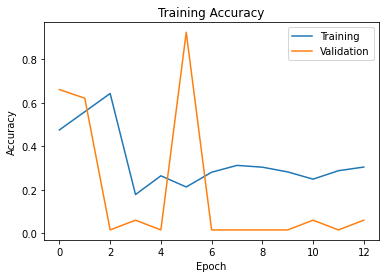

In [108]:
plt.plot( h.history['accuracy'], label='Training' )
plt.plot( h.history['val_accuracy'], label='Validation' )
plt.title('Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

In [109]:
y = to_categorical(yTest)
loss, acc = model.evaluate( xTest, y )
print("Accuracy on the test set:", np.round(acc,4))

6609/6609 [==============================] - 19s 3ms/step - loss: 1.0881 - accuracy: 0.9236
Accuracy on the test set: 0.9236


In [110]:
ps = model.predict(xTest)
predictions = []
for p in ps:
    predictions.append( np.argmax( p ) )
len(predictions)

6609/6609 [==============================] - 8s 1ms/step


211488

In [111]:
print( "Balanced Accuracy:", np.round( balanced_accuracy_score(yTest.values, predictions), 4 ))
print( "Micro F1:", np.round( f1_score(yTest.values, predictions, average='micro'), 4 ))

Balanced Accuracy: 0.3333
Micro F1: 0.9236


## Classify Unknown Buildings in North Carolina

In [113]:
# unknown buildings in North Carolina
url = "https://github.com/geo-smart/flood-risk-ml-tutorial/blob/main/unknownBuildings.zip?raw=true"

unknown = pd.read_csv( url, compression="zip" )
unknown.head()

,StateFips,CountyFips,StateCountyFips,X,Y,Area,MedianIncomeCounty,HousingUnitsCounty,HousingDensityCounty,Impervious,AgCount,CmCount,GvCount,EdCount,InCount,OsmNearestRoad,FEMA_100yr
0,37,99,37099,-83.260602,35.484954,20.716411,22429.0,26649.0,0.618177,2.0,22,2860,3,51,804,tertiary,0.0
1,37,99,37099,-83.155694,35.493472,68.605588,22429.0,26649.0,0.618177,6.0,22,2860,3,51,804,secondary,0.0
2,37,99,37099,-83.155694,35.493287,246.025647,22429.0,26649.0,0.618177,8.0,22,2860,3,51,804,secondary,0.0
3,37,99,37099,-83.154768,35.491620,142.232825,22429.0,26649.0,0.618177,0.0,22,2860,3,51,804,secondary,0.0
4,37,99,37099,-83.158009,35.486898,170.658810,22429.0,26649.0,0.618177,0.5,22,2860,3,51,804,residential,0.0


In [115]:
# read the models from file                                                                                                                                                                                                         
with open('./rf_model_multi.pkl', 'rb') as f:
    rf = pickle.load(f)

In [116]:
# shuffle the dataframe (technically, we randomly resample the entire df)
unknown = unknown.sample(frac=1) 

unknown = unknown.dropna()

nCols = unknown.shape[1]    
le = preprocessing.LabelEncoder()
le.fit( unknown.iloc[:, nCols-2] ) # nearest road type
unknown.iloc[:, nCols-2] = le.transform( unknown.iloc[:, nCols-2] )

In [117]:
unknown.head()

,StateFips,CountyFips,StateCountyFips,X,Y,Area,MedianIncomeCounty,HousingUnitsCounty,HousingDensityCounty,Impervious,AgCount,CmCount,GvCount,EdCount,InCount,OsmNearestRoad,FEMA_100yr
126380,37,119,37119,-80.852176,35.267731,52.609633,36443.0,478966.0,0.429380,18.666667,38,118034,39,2607,17352,4,0.0
150765,37,183,37183,-78.867268,35.787639,413.875972,41189.0,462582.0,0.409578,34.000000,119,105723,30,2778,17780,4,0.0
37354,37,179,37179,-80.529491,35.196898,88.530520,35468.0,83788.0,0.351656,0.000000,44,13966,6,311,5324,4,0.0
201620,37,183,37183,-78.695046,35.782269,26.646813,41189.0,462582.0,0.409578,6.000000,119,105723,30,2778,17780,4,0.0
168469,37,183,37183,-78.547268,35.798194,13.088892,41189.0,462582.0,0.409578,50.333333,119,105723,30,2778,17780,7,0.0


In [118]:
print( unknown.shape[0], 'unknown buildings in North Carolina')

219054 unknown buildings in North Carolina


### Make predictions for all unknown buildings in North Carolina

In [119]:
# generate dataset
X = unknown.drop(['StateFips','CountyFips','StateCountyFips','FEMA_100yr'], axis=1).values

# make predictions
predictions = rf.predict(X)

In [124]:
# 0 = 'Commercial', 1 = 'Industrial', 2 = 'Residential'
pString = []

# update prediction array
for p in predictions:
    if ( p == 0 ):
        pString.append('commercial')
    elif ( p == 1 ):
        pString.append('industrial')
    elif ( p == 2 ):
        pString.append('residential')

# add a column to the dataframe
unknown['predictions'] = pString

print( unknown['predictions'].value_counts() )

residential    212954
commercial       5324
industrial        776
Name: predictions, dtype: int64


In [125]:
unknown.head()

,StateFips,CountyFips,StateCountyFips,X,Y,Area,MedianIncomeCounty,HousingUnitsCounty,HousingDensityCounty,Impervious,AgCount,CmCount,GvCount,EdCount,InCount,OsmNearestRoad,FEMA_100yr,predictions
126380,37,119,37119,-80.852176,35.267731,52.609633,36443.0,478966.0,0.429380,18.666667,38,118034,39,2607,17352,4,0.0,residential
150765,37,183,37183,-78.867268,35.787639,413.875972,41189.0,462582.0,0.409578,34.000000,119,105723,30,2778,17780,4,0.0,residential
37354,37,179,37179,-80.529491,35.196898,88.530520,35468.0,83788.0,0.351656,0.000000,44,13966,6,311,5324,4,0.0,residential
201620,37,183,37183,-78.695046,35.782269,26.646813,41189.0,462582.0,0.409578,6.000000,119,105723,30,2778,17780,4,0.0,residential
168469,37,183,37183,-78.547268,35.798194,13.088892,41189.0,462582.0,0.409578,50.333333,119,105723,30,2778,17780,7,0.0,residential


### Connect predictions with socio-economic data and FEMA 100-year flood predictions

We obtained the 100-year flood map from the FEMA National Flood Hazards Layer. The phrase “100-year flood” is used to describe the extent of a flood that statistically has a 1-percent chance of occurring in any given year [1]. Here, it is used for illustrative purposes of an overall disaster response application. Rows with a 1 in the "FEMA_100yr" column were found be flooded at a significant depth in the FEMA 100-year flood maps.

[1] Maidment, David 2009. “FEMA Flood Map Accuracy.”World Envi-ronmental and Water Resources Congress 2009: Great Rivers1–10.Microsoft. 2018.US Building Footprints.Noy, Natasha, Yuqing Gao, Anshu Ja

In [137]:
flood = unknown[ unknown['FEMA_100yr'] == 1 ]
print(flood.shape[0], "buildings impacted by the 100-year flood")

5838 buildings impacted by the 100-year flood


In [159]:
residential = flood[ flood['predictions'] == 'residential' ]
commercial = flood[ flood['predictions'] == 'commercial' ]
industrial = flood[ flood['predictions'] == 'industrial' ]

print("Residential buildings impacted by 100-year flood:", residential.shape[0])
print("Commercial buildings impacted by 100-year flood:", commercial.shape[0])
print("Industrial buildings impacted by 100-year flood:", industrial.shape[0])

Residential buildings impacted by 100-year flood: 5452
Commercial buildings impacted by 100-year flood: 349
Industrial buildings impacted by 100-year flood: 37


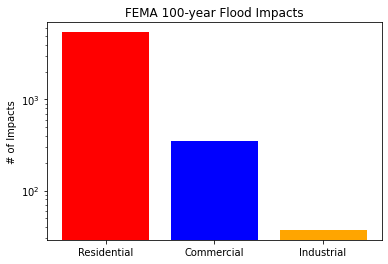

In [139]:
fig, ax = plt.subplots()

types = ['Residential', 'Commercial', 'Industrial']
counts = [ residential.shape[0], commercial.shape[0], industrial.shape[0]]
bar_colors = ['red', 'blue', 'orange']

ax.bar(types, counts, color=bar_colors)

ax.set_ylabel('# of Impacts')
ax.set_title('FEMA 100-year Flood Impacts')
ax.set_yscale('log')

Text(0.5, 0, 'Median Individual Income in County')

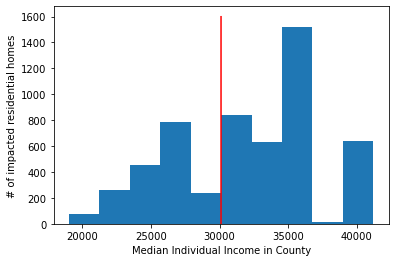

In [145]:
m = 30106 # median individal income in NC in 2020

plt.hist( residential['MedianIncomeCounty'] )
plt.plot( np.zeros(1600)+m, np.arange(0,1600,1), c='red' )
plt.ylabel('# of impacted residential homes')
plt.xlabel('Median Individual Income in County')

In [146]:
ix = np.where( residential['MedianIncomeCounty'] < m )
p = (len(ix[0])/residential['MedianIncomeCounty'].shape[0])*100.
print( np.round(p,2), '% residential buildings impacted are in counties below median income')

33.27 % residential buildings impacted are in counties below median income


Text(0.5, 0, 'Median Individual Income in County')

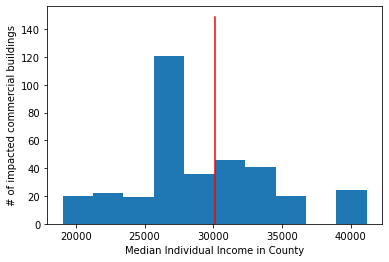

In [153]:
m = 30106 # median individal income in NC in 2020

plt.hist( commercial['MedianIncomeCounty'] )
plt.plot( np.zeros(150)+m, np.arange(0,150,1), c='red' )
plt.ylabel('# of impacted commercial buildings')
plt.xlabel('Median Individual Income in County')

In [148]:
ix = np.where( commercial['MedianIncomeCounty'] < m )
p = (len(ix[0])/commercial['MedianIncomeCounty'].shape[0])*100.
print( np.round(p,2), '% commercial buildings impacted are in counties below median income')

62.46 % commercial buildings impacted are in counties below median income


Text(0.5, 0, 'Median Individual Income in County')

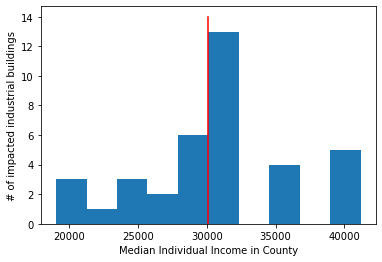

In [154]:
m = 30106 # median individal income in NC in 2020

plt.hist( industrial['MedianIncomeCounty'] )
plt.plot( np.zeros(15)+m, np.arange(0,15,1), c='red' )
plt.ylabel('# of impacted industrial buildings')
plt.xlabel('Median Individual Income in County')

In [155]:
ix = np.where( industrial['MedianIncomeCounty'] < m )
p = (len(ix[0])/industrial['MedianIncomeCounty'].shape[0])*100.
print( np.round(p,2), '% industrial buildings impacted are in counties below median income')

40.54 % industrial buildings impacted are in counties below median income


In [157]:
industrial.shape

(37, 18)